<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/neural_networks/GAN/dcgan_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN (Deep Convolutional Generative Adversarial Network)

In [1]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.__version__

TensorFlow 2.x selected.


'2.1.0-rc1'

In [0]:
# do generownia gifów
!pip install -q imageio

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

## Załadowanie i przygotowanie zbioru danych

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # normalizacja obrazów z [0, 255] do [-1, 1]

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# podzielenie na wsady i przetasowanie danych
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Stworzenie modeli
### Generator

In [0]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256))) 
  assert model.output_shape == (None, 7, 7, 256)  # Note: None to rozmiar wsadu (batch_size)

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

Użycie (jeszcze niewytrenowanego) generatora do stworzenia obrazu.

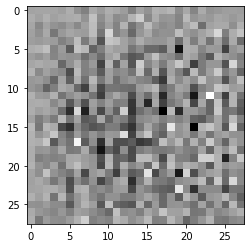

In [8]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Dyskryminator

In [0]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                          input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

Użycie (jeszcze niewytrenowanego) dyskryminatora do sklasyfikowania wygenerowanych obrazów jako rzeczywiste albo nierealne. Model będzie uczony na dodatnich wartościach dla obrazów rzeczywistych i ujemnych dla nierealnych.

In [10]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00062261]], shape=(1, 1), dtype=float32)


## Deklaracja straty i optymalizatora

In [0]:
# ten model zwraca funkcję pomocniczą do obliczenia entropii krzyżowej straty
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Strata dyskryminatora

In [0]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

### Strata generatora

In [0]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

Dyskryminator i generator są różne, ponieważ są trenowane jako dwie niezależne sieci.

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Zapisanie punktów kontrolnych

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Pętla treningowa

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# będziemy używać tego seeda z biegiem czasu
# do wizualizacji postępów na animowanym gifie
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# używamy tf.function
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # robienie obrazów do gifu
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # zapis modelu co 15 epok
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

  # generowanie po ostatniej epoce
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

Generowanie i zapis obrazów

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # zauważ, że 'training' ustawiony jest na fałsz
  # wszystkie warstwy działają w trybie wnioskowania inference mode(batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.axis()

## Trenowanie modelu
Wywołujemy metodę `train()` na generatorze i dyskryminatorze równocześnie. Ponieważ GANy mogą zdradzieckie, ważne jest aby generator i dyskryminator nie zwalczały siebie nawzajem.

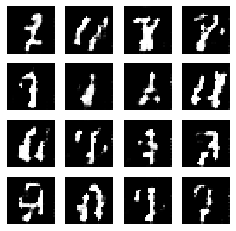

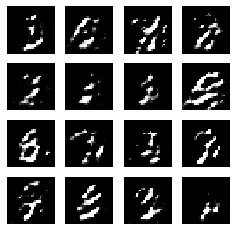

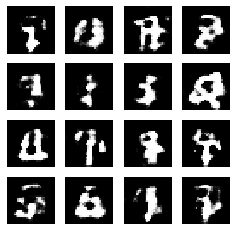

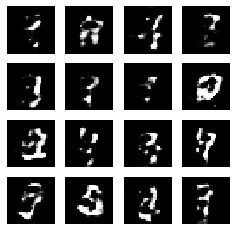

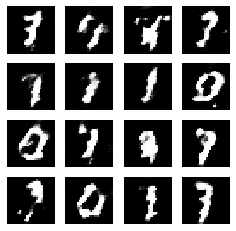

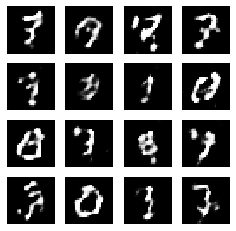

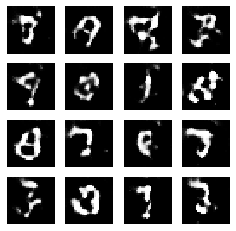

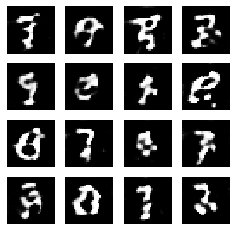

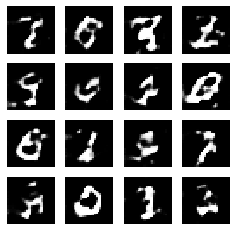

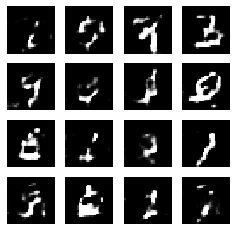

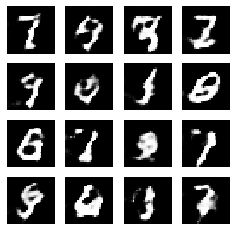

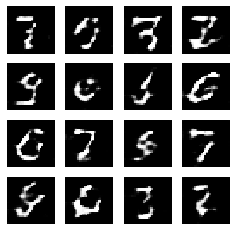

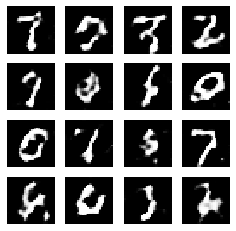

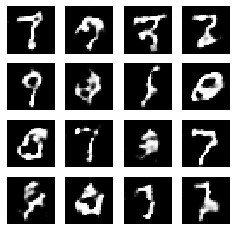

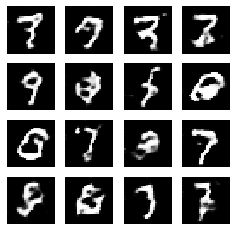

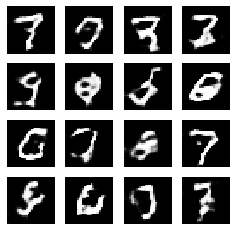

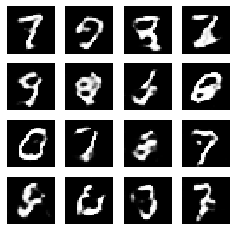

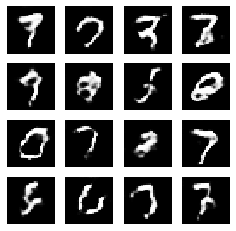

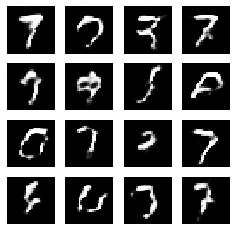

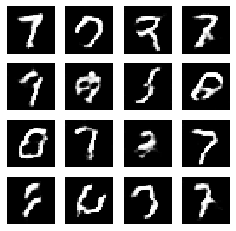

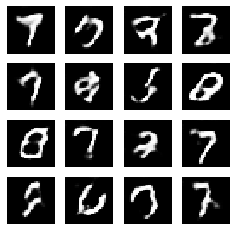

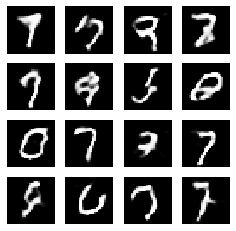

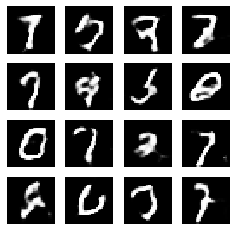

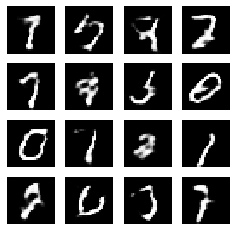

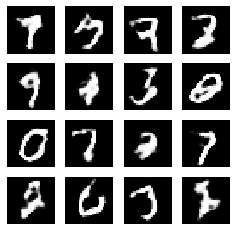

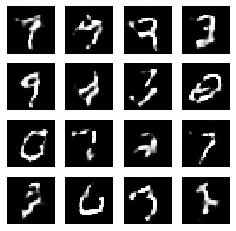

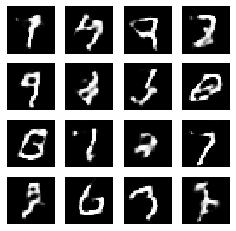

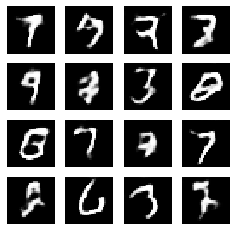

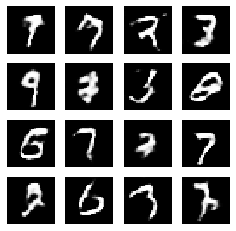

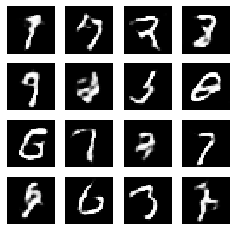

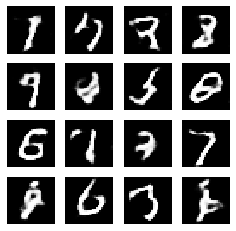

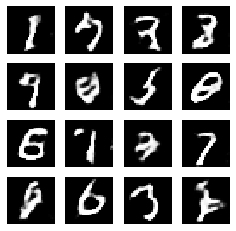

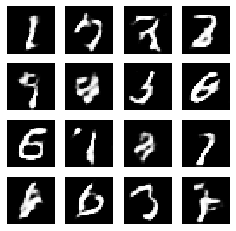

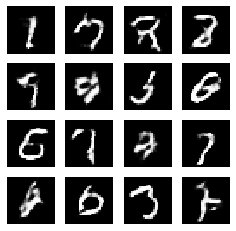

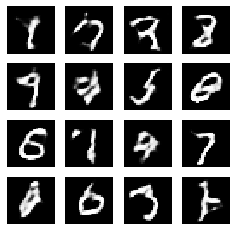

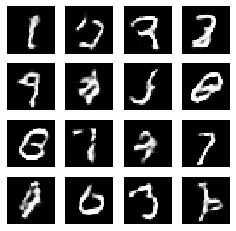

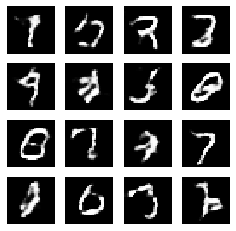

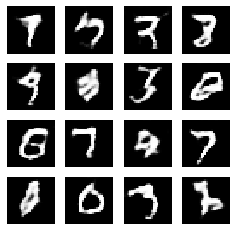

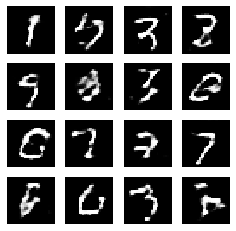

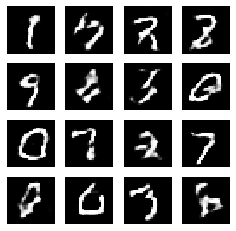

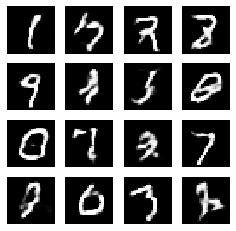

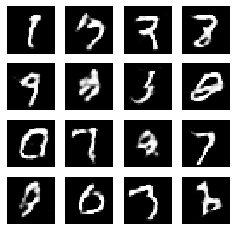

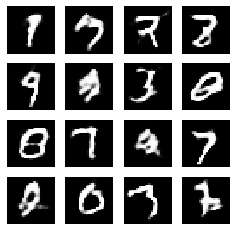

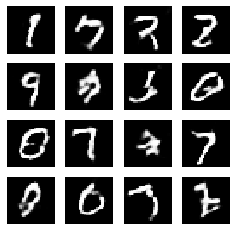

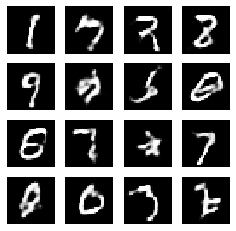

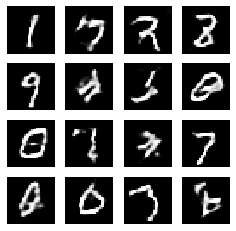

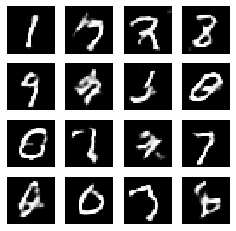

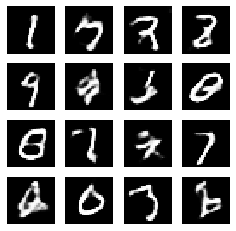

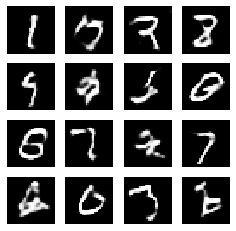

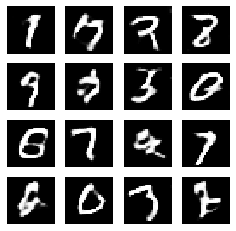

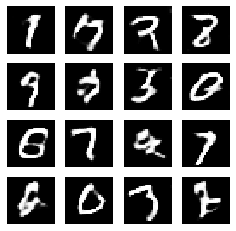

In [22]:
train(train_dataset, EPOCHS)

Przywracamy ostatni checkpoint.

In [23]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Tworzymy GIF

In [0]:
# wyświetl pojedynczy obraz z użyciem numery epoki
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

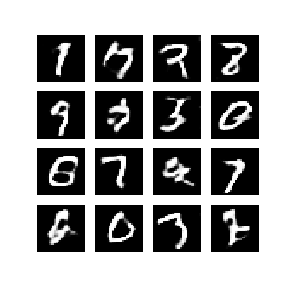

In [38]:
display_image(EPOCHS)

Użyjemy imageio do stworzenia animowanego gifa z obrazów zapisanych podczas treningu.

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i, filename in enumerate(filenames):
    frame = 2 * (i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

  import IPython
  if IPython.version_info > (6, 2, 0, ''):
    display.Image(filename=anim_file)

Tylko w Colab: możecie pobrać animację z poniższym kodem.

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)